# Setup

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sys

from deap import algorithms, base, creator, tools

from sympy import *

from scipy.stats import spearmanr

sys.path.append('../promoter_solving/')
from promoter_solving_core import *

In [4]:
# Load csv with mRNA_ratio, MA_act, MA_inh
data = pd.read_csv('../data/pickle_dfs/zerod_M_MA_for_activator_inhibitor_and_mRNA_ratios_df.csv', index_col=0)
data.head()

,MA_activator,MA_inhibitor,actual_mRNA_ratio
control__wt_glc__1,0.019182,0.028499,2.186692
control__wt_glc__2,-0.019182,-0.028499,2.369230
fur__wt_dpd__1,-0.963901,-0.473642,0.490542
fur__wt_dpd__2,-1.116929,-0.541595,0.492320
fur__wt_fe__1,0.043720,-0.054857,1.756930


# Create Grids for Each Condition

In [5]:
grid = pd.DataFrame(columns = ['mRNA_ratio','grid'], index = data.index)
grid.loc[:,'mRNA_ratio'] = data.loc[:,'actual_mRNA_ratio']

In [6]:
equation = sympify('Eq(mRNARatio,((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
KeqOpening)*RNAP))')
equation

Eq(mRNARatio, (KdRNAP*cActivator + KdRNAPCrp)*(KdRNAP + KeqOpening*RNAP + RNAP)/(KdRNAP*KdRNAPCrp*(cActivator + cInhibitor + 1) + KdRNAP*RNAP*cActivator*(KeqOpening + 1) + KdRNAPCrp*RNAP*(KeqOpening + 1)))

In [7]:
# Define constants
constant_vals = {
    # NOTE: MAKE SURE TO UPDATE IF ANYTHING IS CHANGED
    'KdRNAP': 10**-5,
    'KdRNAPCrp': 2.5118864315095796e-07*1.4,
    'KeqOpening': 10**-0.34444956947383365,
    'RNAP': 10**-6, 
}

In [8]:
# Create lambda functions that we can plug in to
lambda_df = create_lambdas(equation, constant_vals)

# Parameter we are solving for using the other two
solve = 'cInhibitor' # Solve for this by setting the other (e.g. solve = cInhibitor if cActivator is known)

input_range = {
    'cActivator': [0,10],
    #'cInhibitor': [0,50],
}

for i, condition in enumerate(grid.index):
    # Create a working grid based on cActivator, we will add cInhibitor values 
    # to it to ensure they always result in mRNA ratio
    working_grid = create_parameter_grid(num_steps = 101, **input_range)

    # Use a dict just in case order of tuple to sub into lambda function ever changes
    values = {'mRNARatio': grid.loc[condition,'mRNA_ratio']}
    for ii, pair in enumerate(working_grid):
        values[list(input_range.keys())[0]] = pair[0] #NOTE: May break if we try to run both at same time
        
        # Create a tuple in the correct order to pass into the lambda function
        values_tuple = tuple([values[p] for p in lambda_df.loc[solve,'order']])
    
        # Evaluate the lambda function, order is currently (cActivator, cInhibitor)
        working_grid[ii] += ((lambda_df.loc[solve,'lambda'](values_tuple))[0],)
    
    # Save to grid df
    grid.at[condition, 'grid'] = working_grid

In [240]:
lambda_df.equation[0]

[5.0e-16*(-3.51664100411341e+28*cInhibitor*mRNARatio - 4.02740814026198e+28*mRNARatio + 4.02740814026197e+28)/(90204654800503.0*mRNARatio - 572621449779935.0)]

In [68]:
grid.head()

,mRNA_ratio,grid
control__wt_glc__1,2.186692,"[(0.0, -0.6215098252031866), (0.1, 0.354773407..."
control__wt_glc__2,2.369230,"[(0.0, -0.6618609214775106), (0.1, 0.199679019..."
fur__wt_dpd__1,0.490542,"[(0.0, 1.1894055061723103), (0.1, 7.3152485865..."
fur__wt_dpd__2,0.492320,"[(0.0, 1.180971427188386), (0.1, 7.28283116958..."
fur__wt_fe__1,1.756930,"[(0.0, -0.49339972486388645), (0.1, 0.84718029..."


# DEAP

In [99]:
creator.create(name = 'fitness',
               base = base.Fitness,
               weights = (1.0, -1.0,)) # Set to maximize Spearman correlation of MA_activator and cActivator, and minimize MA_inhibitor and cInhibitor

creator.create(name = 'individual',
               base = np.ndarray,
               fitness = creator.fitness)

toolbox = base.Toolbox()

random.seed(42)

def generate_individual(individual_class: type, data: pd.DataFrame):
    individual = individual_class(random.sample(grid,1)[0] for grid in grid['grid'])
    
    return individual

toolbox.register(alias = 'individual',
                 function = generate_individual,
                 individual_class = creator.individual,
                 data = grid)

toolbox.register('population',
                 tools.initRepeat,
                 list,
                 toolbox.individual)

/opt/miniconda3/envs/sym-seq-ml/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/miniconda3/envs/sym-seq-ml/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [100]:
test_population = toolbox.population(n=3)

In [101]:
# Evaluate
MA_df = data.iloc[:,0:2]

def spearman_objective(individual: object, MA_df: pd.DataFrame):
    """
    Calculate spearman coefficient between cAct/cInh and MA_act/MA_inh
    :param object individual: DEAP individual
    :param pd.DataFrame MA_df: Df with columns = ['MA_activator','MA_inhibitor']
    """

    MA_activator = MA_df.loc[:,'MA_activator']
    MA_inhibitor = MA_df.loc[:,'MA_inhibitor']
    
    # NOTE: Need to swap 0 and 1 depending if calculating using cInhibitor or cActivator
    # NOTE: This is hardcoded and may break depending on if we try to run the two simultaneously
    if solve == 'cInhibitor':
        ind_activator = individual[:,0]
        ind_inhibitor = individual[:,1]
    else:
        ind_activator = individual[:,1]
        ind_inhibitor = individual[:,0]
    
    activator_spearman = spearmanr(MA_activator, ind_activator)[0]
    inhibitor_spearman = spearmanr(MA_inhibitor, ind_inhibitor)[0]
    
    return activator_spearman, inhibitor_spearman,

toolbox.register(alias = 'evaluate', function = spearman_objective, MA_df = MA_df)

In [102]:
toolbox.evaluate(test_population[0])

(0.04163016706958983, -0.6884556869279006)

In [241]:
toolbox.register("select", tools.selNSGA2, nd='log')

In [104]:
# Mutation
def mutate(individual: object, prob: float, data: pd.DataFrame):
    for i, _ in enumerate(individual):
        if random.random() < prob:
            individual[i] = random.sample(grid.iloc[i,1],1)[0]

    return individual,

mt_prob = 0.1  #NOTE: CHANGE ME
toolbox.register('mutate', function = mutate, prob = mt_prob, data = data)

In [105]:
# Crossover
def crossover(ind_one: object, ind_two: object, prob: float,):

    for i, _ in enumerate(ind_one):
        if random.random() < prob:
            ind_one[i], ind_two[i] = ind_two[i].copy(), ind_one[i].copy()

    return ind_one, ind_two

cx_prob = 0.1 # NOTE: CHANGE ME

toolbox.register(alias = "mate", function = crossover, prob = cx_prob,)

In [227]:
stats = tools.Statistics(lambda ind: ind.fitness.values) # Note: update these to actually be useful
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [242]:
# NOTE: Using np.ndarray individuals requires a different method to compare individuals
hof = tools.HallOfFame(3, similar=np.array_equal)

nind = 100
mu = 50
lambda_ = 100
cxpb = 0.7
mutpb = 0.3
ngen = 1000

pop, logbook = algorithms.eaMuPlusLambda(toolbox.population(n=nind), toolbox, mu=mu, lambda_=lambda_, 
            cxpb=cxpb, mutpb=mutpb, ngen=ngen, stats=stats, halloffame=hof, verbose=False)

In [254]:
"""
- Implement "gradient offspring" using output to test the method
- NSGA-II works in the objective function space, we want to work in the parameter space
- Partial derivative of the mRNA ratio equation isn't useful because that is not our objective function
- Spearman function is ranked based so it does not have any gradient information
- Goal: While holding parameters from all other conditions the same, evaluate the change in fitness of an individual whose parameters have been modified.
    - Throw these individuals into the population that is selected from to seed the next generation
"""

n_steps = 1
n_conditions = len(hof[0])
temp_fitness = hof[0].fitness
temp_population = toolbox.population(n=0) # Create population class to hold the individuals we are trying out

# Rather than deal with having to look up where the tuple is, I think my next step should be to make the first n tuples correspond to the locations of the n parameters that are set in each tuple
# For this case, that would mean that the first number would correspond to the position of the cAct value in the list

for i, (act, inh) in enumerate(hof[0]): # Iterate over each condition's parameters in the hof individual
    for ii, (grid_act, grid_inh) in enumerate(grid.grid[i]): # Locate the position of the tuple in the grid. I'm worried about rounding errors, so I want to shift to the method described above.
        if (act, inh) == (grid_act, grid_inh):
            position = ii

    # For each condition, evaluate the fitness of changing one condition's parameters at a time.
    temp_individual = creator.individual(hof[0])
    temp_individual[i] = position+1
    temp_individual.fitness.values = toolbox.evaluate(temp_individual)

    # Add them back to the population
    temp_population.append(temp_individual)

In [257]:
hof[0].fitness.values

(0.7631547012464964, -0.7989542717003838)

In [256]:
temp_population[0].fitness.values

(0.7589069339646894, -0.7989741058865871)

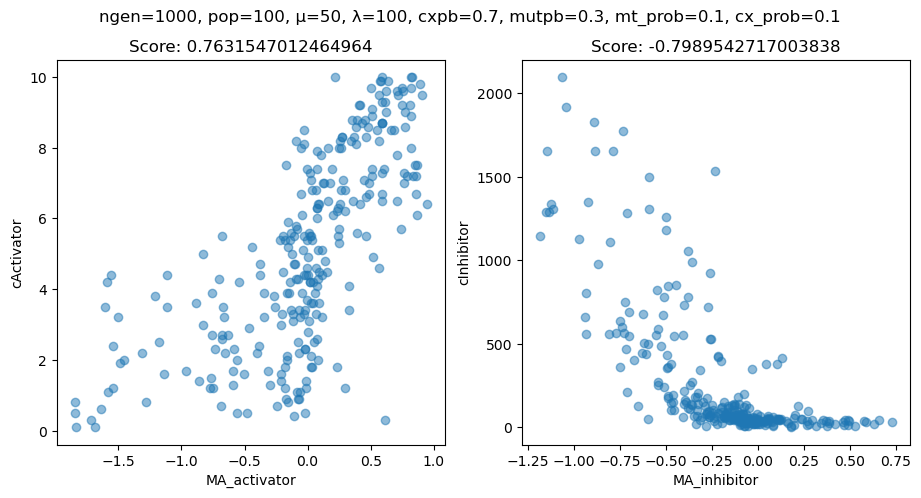

In [243]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (11,5), squeeze= True)
title = 'ngen='+str(ngen)+', pop='+str(nind)+', μ='+str(mu)+', λ='+str(lambda_)+', cxpb='+str(cxpb)+', mutpb='+str(mutpb)+', mt_prob='+str(mt_prob)+', cx_prob='+str(cx_prob)
fig.suptitle(title)
ax1.set_xlabel('MA_activator')
ax2.set_xlabel('MA_inhibitor')
ax1.set_ylabel('cActivator')
ax2.set_ylabel('cInhibitor')

eval_act, eval_inh = toolbox.evaluate(hof[0])
ax1.set_title('Score: '+str(eval_act))
ax2.set_title('Score: '+str(eval_inh))

if solve == 'cInhibitor':
    # If cActivator is used to calculate cInhibitor
    ax1.scatter(MA_df.iloc[:,0], hof[0][:,0], alpha=0.5)
    ax2.scatter(MA_df.iloc[:,1], hof[0][:,1], alpha=0.5)
else: 
    # If cInhibitor is used to calculate cActivator
    ax1.scatter(MA_df.iloc[:,0], hof[0][:,1], alpha=0.5)
    ax2.scatter(MA_df.iloc[:,1], hof[0][:,0], alpha=0.5)

Text(0, 0.5, 'Total Spearman [cAct-cInh]')

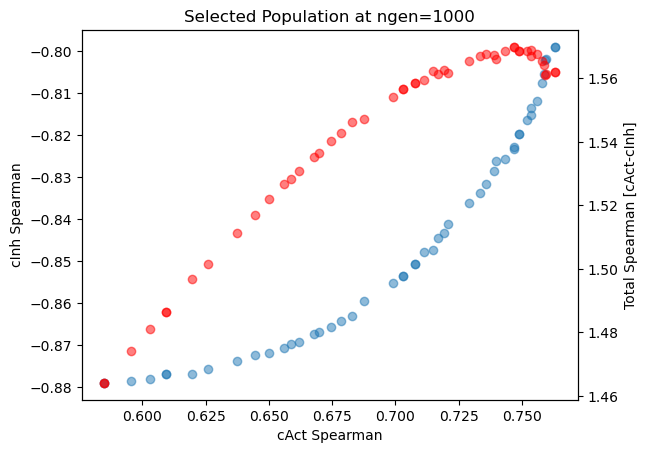

In [244]:
a, b = zip(*[pop[i].fitness.values for i in range(len(pop))])

fig, ax1 = plt.subplots()
ax1.scatter(a,b, alpha=0.5)
ax2 = ax1.twinx()
ax2.scatter(a,np.subtract(a,b), alpha=0.5, c='r')
ax1.set_title('Selected Population at ngen='+str(ngen))
ax1.set_xlabel('cAct Spearman')
ax1.set_ylabel('cInh Spearman')
ax2.set_ylabel('Total Spearman [cAct-cInh]')